In [ ]:
# !git clone https://github.com/ZuoyiLi/vit-pytorch
# !git clone https://github.com/lucidrains/vit-pytorch
# https://github.com/rwightman/pytorch-image-models
!pip install adversarial-robustness-toolbox
!pip install timm
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.0)


In [ ]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


In [ ]:
model = timm.create_model('vit_large_patch16_224', pretrained=True)
# model.eval()

In [ ]:
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)
img = Image.open(filename).convert('RGB')
tensor = transform(img).unsqueeze(0) # transform and add batch dimension
img

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# get prob output
with torch.no_grad():
    out = model(tensor)
probabilities = torch.nn.functional.softmax(out[0], dim=0)
print(probabilities.shape)
# prints: torch.Size([1000])

torch.Size([1000])


In [ ]:
# Get imagenet class mappings
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
urllib.request.urlretrieve(url, filename) 
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Print top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

def get_top5(img_tensor, probabilities, categories):
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    labels = []
    lab_pos = []
    for i in range(top5_prob.size(0)):
        labels.append(categories[top5_catid[i]])
        lab_pos.append(top5_prob[i].item())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.imshow(np.swapaxes(adv_1[0].T, 0, 1))
    ax2.bar(np.arange(5), lab_pos, color='green')
    ax2.set(xlabel='Labels', ylabel='Probabilities')
    ax2.set_xticks(np.arange(5))
    ax2.set_xticklabels(labels)
    plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
    fig.suptitle('PGD-20 attack on ViT')
    fig.show()

cock 0.7729102969169617
hen 0.1825842708349228
peacock 0.01035380456596613
partridge 0.004648508969694376
vulture 0.001068733399733901


In [ ]:
# TEST
tensor.shape
np.arange(5)*40

array([  0,  40,  80, 120, 160])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=1000,
)

# set up PGD-20 attack
eps = 0.03
attack = ProjectedGradientDescentPyTorch(
        estimator=classifier,
        norm="inf",
        eps=eps,
        targeted=True,
        eps_step=0.05,
        max_iter=20
)

In [ ]:
adv_1 = attack.generate(x=tensor, y=np.array([7]))

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:670: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:671: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


In [ ]:
with torch.no_grad():
    out = model(torch.from_numpy(adv_1).to('cuda'))
probabilities = torch.nn.functional.softmax(out[0], dim=0)

top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

cock 0.7729102969169617
hen 0.1825842708349228
peacock 0.01035380456596613
partridge 0.004648508969694376
vulture 0.001068733399733901


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


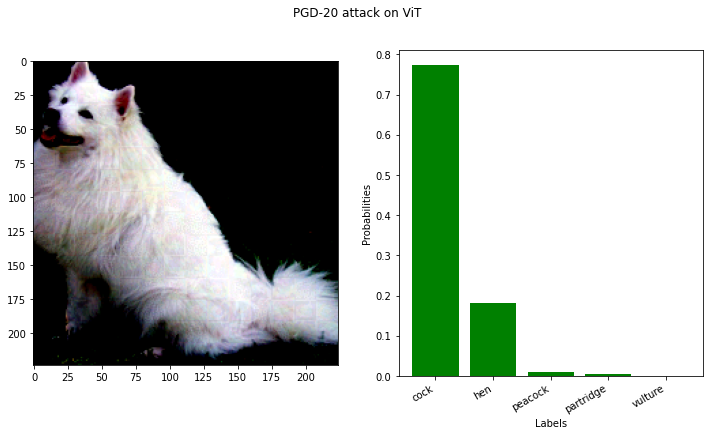

In [ ]:
get_top5(adv_1, probabilities, categories)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


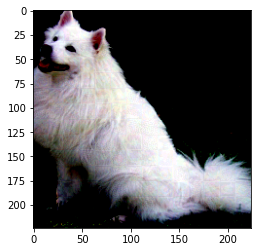

In [ ]:
adv_img = np.swapaxes(adv_1[0].T, 0, 1)
plt.imshow(adv_img)